Data Preprocessing:

Load dataset and split data into training, validation, and testing data

In [127]:
import sklearn
import numpy as np
from operator import index
from numpy import number
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix

# Load breast cancer dataset
data = sklearn.datasets.load_breast_cancer()

label = data.target
data = data.data

# Divide data into training, validation, and testing data. Data is divided into features and labels
trainingFeatures, remainingFeatures, trainingLabels, remainingLabels = train_test_split(data, label, test_size=0.3, random_state=20, stratify=label)
validationFeatures, testingFeatures, validationLabels, testingLabels = train_test_split(remainingFeatures, remainingLabels, test_size=0.5, random_state=20, stratify=remainingLabels)

Creating a "Node" class, which creates the nodes found in the tree

In [128]:
class Node:
  def __init__(self, featureChosen=None, threshold=None, left=None, right=None, informationGain=None, entropy=None, value=None):
    # Intializing each node with the values provided to it from the previous pass.
    # Each node would contain the information gain associated with it, its entropy, and the feature which brought it about.
    self.featureChosen = featureChosen
    self.threshold = threshold
    self.left = left
    self.right = right
    self.informationGain = informationGain
    self.entropy = entropy
    self.value = value


Creating a "Tree" class, which handles the logic for the implementation of the entire tree

In [129]:
class DecisionTree:
  def __init__(self, minSamplesSplit=2, maxDepth=2):
    # Intializes the root of the tree. Placed as None as the tree originally has no root defined to it.
    self.root = None
    # Identifies the stopping condition for the tree.
    self.minSamplesSplit = minSamplesSplit
    self.maxDepth = maxDepth

  def makeTree(self, trainingFeatures, trainingLabels, currentDepth=0):
    numberofSamples = trainingLabels.shape[0]
    numberofFeatures = trainingFeatures.shape[1]
    pureSplit = len(np.unique(trainingLabels)) == 1

    # Account for stopping conditions
    if currentDepth <= self.maxDepth and numberofSamples >= self.minSamplesSplit and not pureSplit:
      # Get optimal split
      optimalSplit = self.getOptimalSplit(trainingFeatures, trainingLabels, numberofSamples, numberofFeatures)

      # Ensure current optimal split has a positive information gain
      if optimalSplit["informationGain"] > 0:
        # Build left subtree
        leftSubtree = self.makeTree(optimalSplit["leftFeatures"], optimalSplit["leftLabels"], currentDepth + 1)

        # Build right subtree
        rightSubtree = self.makeTree(optimalSplit["rightFeatures"], optimalSplit["rightLabels"], currentDepth + 1)

        return Node(optimalSplit["featureChosen"], optimalSplit["threshold"], leftSubtree, rightSubtree, optimalSplit["informationGain"])

    # If stopping conditions are met, then this is currently a leaf node.
    leaf = self.makeLeafNode(trainingLabels)
    return Node(value=leaf)

  def getOptimalSplit(self, trainingFeatures, trainingLabels, numberofSamples, numberofFeatures):
    # Create dictionary to store best split
    bestSplit = {}
    # Intialize the maximum information gain with minus infinity
    # This is crucial as the greedy algorithm must intially start from a low value and then increment it
    maxInformationGain = -float("inf")

    # Loop over all possible features to determine which feature will provide the best split
    for featureIndex in range(numberofFeatures):
      featureValues = trainingFeatures[:, featureIndex]
      possibleThresholds = np.unique(featureValues)
      for threshold in possibleThresholds:
        # Split according to current given values
        dataLeft, dataRight, labelsLeft, labelsRight = self.split(trainingFeatures, trainingLabels, featureIndex, threshold)
        # Ensure both left and right children are not null
        if len(dataLeft) > 0 and len(dataRight) > 0:
          informationGain = self.informationGain(trainingLabels, labelsLeft, labelsRight)
          # Update current split if the information gain obtained from current split yields a higher value from the supposed maximum information gain
          if informationGain > maxInformationGain:
            bestSplit["featureChosen"] = featureIndex
            bestSplit["threshold"] = threshold
            bestSplit["leftFeatures"] = dataLeft
            bestSplit["leftLabels"] = labelsLeft
            bestSplit["rightFeatures"] = dataRight
            bestSplit["rightLabels"] = labelsRight
            bestSplit["informationGain"] = informationGain
            maxInformationGain = informationGain

    # Return the current best split
    return bestSplit

  def split(self, trainingFeatures, trainingLabels, featureIndex, threshold):
    dataLeft = np.array([row for row in trainingFeatures if row[featureIndex] <= threshold])
    dataRight = np.array([row for row in trainingFeatures if row[featureIndex] > threshold])
    labelsLeft = trainingLabels[trainingFeatures[:, featureIndex] <= threshold]
    labelsRight = trainingLabels[trainingFeatures[:, featureIndex] > threshold]
    return dataLeft, dataRight, labelsLeft, labelsRight

  def makeLeafNode(self, trainingLabels):
    trainingLabels = np.array(trainingLabels)
    return max(set(trainingLabels), key=list(trainingLabels).count)

  def getEntropy(self,trainingLabels):
    labels = np.unique(trainingLabels)
    # Intialize entropy with zero
    entropy = 0
    for label in labels:
      # Calculate the probability of occurence of the label
      probability = len(trainingLabels[trainingLabels == label]) / len(trainingLabels)
      entropy += -probability * np.log2(probability)
    return entropy

  def informationGain(self, labelCurrent, labelLeft, labelRight):
    # Get the weight of the left and right children from the total number of labels
    weightedLeft = len(labelLeft) / len(labelCurrent)
    weightedRight = len(labelRight) / len(labelCurrent)

    # Calculate the information gain
    infoGain = self.getEntropy(labelCurrent) - (weightedLeft * self.getEntropy(labelLeft) + weightedRight * self.getEntropy(labelRight))
    return infoGain

  def printTree(self, tree=None, indent=" "):
    if not tree:
      tree = self.root
    if tree.value is not None:
      if tree.value == 1:
        print("Malignant")
      elif tree.value == 0:
        print("Benign")
      else:
        print(tree.value)
    else:
      print("X"+str(tree.featureChosen), "<=", tree.threshold, "?")
      print("%sInformation Gain: " % (indent),tree.informationGain)
      print("%sleft:" % (indent), end="")
      self.printTree(tree.left, indent + indent)
      print("%sright:" % (indent), end="")
      self.printTree(tree.right, indent + indent)

  def fit(self, trainingFeatures, trainingLabels):
    self.root = self.makeTree(trainingFeatures, trainingLabels)

  def predict(self, testingFeatures):
    predictions = [self.makePredictions(row, self.root) for row in testingFeatures]
    return predictions

  def makePredictions(self, testingFeatures, tree):
    if tree.value != None:
      return tree.value
    featureValue = testingFeatures[tree.featureChosen]
    if featureValue <= tree.threshold:
      return self.makePredictions(testingFeatures, tree.left)
    else:
      return self.makePredictions(testingFeatures, tree.right)

  def accuracy(self, testingFeatures, testingLabels):
    predictions = self.predict(testingFeatures)
    return np.mean(np.array(predictions) == np.array(testingLabels))

In [130]:
tree = DecisionTree(minSamplesSplit=3,maxDepth=3)
tree.fit(trainingFeatures, trainingLabels)
tree.printTree()

X22 <= 105.9 ?
 Information Gain:  0.645947668978021
 left:X27 <= 0.1423 ?
  Information Gain:  0.09557508006087603
  left:X3 <= 690.2 ?
    Information Gain:  0.03145500992451482
    left:X14 <= 0.00328 ?
        Information Gain:  0.023338451601787248
        left:Malignant
        right:Malignant
    right:Benign
  right:X13 <= 18.15 ?
    Information Gain:  0.6394725269414906
    left:X1 <= 20.22 ?
        Information Gain:  0.6500224216483541
        left:Malignant
        right:Benign
    right:Benign
 right:X27 <= 0.1489 ?
  Information Gain:  0.2080739414679902
  left:X21 <= 19.31 ?
    Information Gain:  0.29469601591956374
    left:Malignant
    right:X20 <= 16.76 ?
        Information Gain:  0.3515358797217579
        left:Malignant
        right:Benign
  right:Benign


In [131]:
# Testing the tree
print("Tree Accuracy on Validation Data:", tree.accuracy(validationFeatures,validationLabels))

Tree Accuracy on Validation Data: 0.9176470588235294


Fine Tuning the Hyperparameters:

Maximum Tree Depth and Minimum Samples Per Split

In [132]:
def tuning(minSamplesSplit, maxDepth):
  trainingTree = DecisionTree(minSamplesSplit=minSamplesSplit,maxDepth=maxDepth)
  trainingTree.fit(trainingFeatures, trainingLabels)
  return trainingTree.accuracy(validationFeatures, validationLabels)

def multipleRuns(minSamplesSplit=[2,5,10], maxDepth=[2,4,6,8,10]):
  optimalSampleSplit = 0
  optimalMaxDepth = 0
  maxAccuracy = 0

  for sampleSplit in minSamplesSplit:
    for depth in maxDepth:
      accuracy = tuning(sampleSplit, depth)
      if accuracy > maxAccuracy:
        maxAccuracy = accuracy
        optimalSampleSplit = sampleSplit
        optimalMaxDepth = depth
  print("Hyperparameter Tuning:")
  print("Minimum Samples Per Split:", optimalSampleSplit)
  print("Maximum Tree Depth:", optimalMaxDepth)
  print("Maximum Accuracy:", maxAccuracy)
  return optimalSampleSplit, optimalMaxDepth, maxAccuracy

minSampleSplit, maxDepth, maxAccuracy = multipleRuns()


Hyperparameter Tuning:
Minimum Samples Per Split: 2
Maximum Tree Depth: 4
Maximum Accuracy: 0.8941176470588236


In [133]:
tree = DecisionTree(minSamplesSplit=minSampleSplit,maxDepth=maxDepth)
tree.fit(trainingFeatures, trainingLabels)
# Test optimal minSamplesSplit and maxDepth on testing data
predictions = tree.predict(testingFeatures)
print("Tree Accuracy on Testing Data:", tree.accuracy(testingFeatures,testingLabels))

Tree Accuracy on Testing Data: 0.9302325581395349


Maximum Tree Depth: 2
Training Accuracy: 0.9748743718592965
Validation Accuracy: 0.8823529411764706
Maximum Tree Depth: 4
Training Accuracy: 0.9949748743718593
Validation Accuracy: 0.8941176470588236
Maximum Tree Depth: 6
Training Accuracy: 1.0
Validation Accuracy: 0.8823529411764706
Maximum Tree Depth: 8
Training Accuracy: 1.0
Validation Accuracy: 0.8823529411764706
Maximum Tree Depth: 10
Training Accuracy: 1.0
Validation Accuracy: 0.8823529411764706


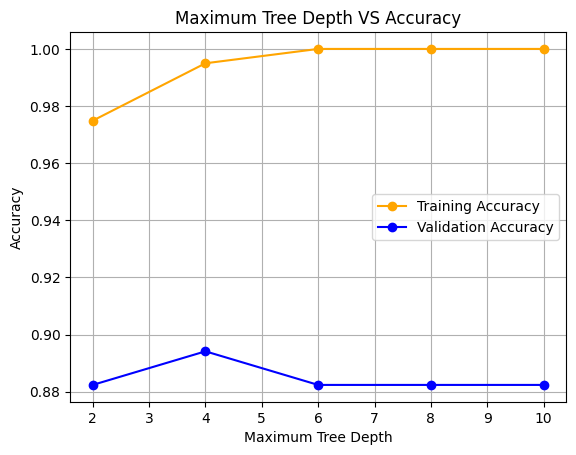

In [134]:
# Examining training and validation accuracy change with maximum depth, while keeping the minimum samples to split on at a constant number, 2.
samples=[2,4,6,8,10]
trainingAccuracyData=[]
validationAccuracyData=[]
def accuracyChange(samples=[2,4,6,8,10]):
  for depth in samples:
    trainingTree = DecisionTree(minSamplesSplit=2,maxDepth=depth)
    trainingTree.fit(trainingFeatures, trainingLabels)
    trainingAccuracy = trainingTree.accuracy(trainingFeatures, trainingLabels)
    validationAccuracy = trainingTree.accuracy(validationFeatures, validationLabels)
    print("Maximum Tree Depth:", depth)
    print("Training Accuracy:", trainingAccuracy)
    print("Validation Accuracy:", validationAccuracy)
    trainingAccuracyData.append(trainingAccuracy)
    validationAccuracyData.append(validationAccuracy)

def plotAccuracyChange(samples, trainingAccuracyData, validationAccuracyData):
  plt.plot(samples, trainingAccuracyData, label='Training Accuracy', linestyle='-', marker='o', color='orange')
  plt.plot(samples, validationAccuracyData, label='Validation Accuracy', linestyle='-', marker='o', color='blue')
  plt.xlabel('Maximum Tree Depth')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid()
  plt.title('Maximum Tree Depth VS Accuracy')
  plt.show()

accuracyChange()
plotAccuracyChange(samples, trainingAccuracyData, validationAccuracyData)



Classification Report for Testing Data:
------------
Benign: Positive || Malignant: Negative
Precision:  0.8823529411764706
Recall:  0.9375
F1-Score:  0.9090909090909091
------------
Confusion Matrix for Testing Data:
------------


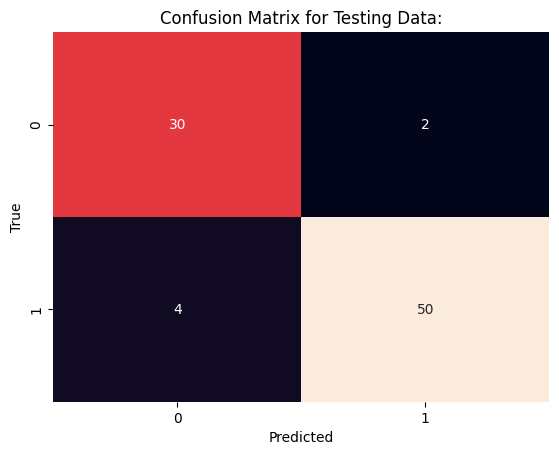

In [139]:
tree = DecisionTree(minSamplesSplit=minSampleSplit,maxDepth=maxDepth)
tree.fit(trainingFeatures, trainingLabels)
# Test optimal minSamplesSplit and maxDepth on testing data
predictions = tree.predict(testingFeatures)

numpyPredictions = np.array(predictions)
numpyActualLabels = np.array(testingLabels)

# Performance Metrics

# Calculating the precision, recall, and f-score
# Precision: How many positively predicted instances the model predicted were actually positive
# Recall: Out of all of the positive instances, how many did the model correctly preicted
# F1-Score: Harmonic mean of both the precision and the recall. Heavily penalizes extreme values in either cases
true_positives = np.sum(np.logical_and(numpyPredictions == 0, numpyActualLabels == 0))
true_negatives = np.sum(np.logical_and(numpyPredictions == 1, numpyActualLabels == 1))
false_positives = np.sum(np.logical_and(numpyPredictions == 0, numpyActualLabels == 1))
false_negatives = np.sum(np.logical_and(numpyPredictions == 1, numpyActualLabels == 0))

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Classification Report for Testing Data:")
print("------------")
print("Benign: Positive || Malignant: Negative")
print("Precision: ",precision)
print("Recall: ",recall)
print("F1-Score: ",f1_score)
print("------------")

# Confusion Matrix

print("Confusion Matrix for Testing Data:")
print("------------")

confusionMatrix = confusion_matrix(testingLabels, predictions)
plt.figure()
sn.heatmap(confusionMatrix, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Testing Data:')
plt.show()

